## Assigning essentiality labels using E. coli K-12 datasets

Challenge: I generated transposon sequencing data for E. coli B REL606, which is less commonly used compared to E. coli K-12. Since there isn't a well-annotated ground truth of gene essentiality for the REL606 strain, I will use a dataset from E. coli K-12 as a benchmark. 

1. The E. coli K-12 Keio collection: in this experiment, the authors attempted to make gene deletions for every gene in the K-12 genome. They were unable to make deletions in ~300 genes, which are considered essential. 
2. The E. coli K-12 TraDIS collection: a transposon sequencing experiment where the authors did a manual examination of several edge cases and annotated essentiality based on both sequencing data and prior results in the literature.

Challenge: there are several unannotated genes in the E. coli genome, and the two strains can differ in their gene content. To get around these issues, I will identify all the genes that are shared between the REL606 and K-12 genome and extract essentiality labels only for those.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
#current working directory
repo = os.getcwd()
print(repo)

/Users/anuraglimdi/github/essentiality-predictor


In [3]:
metadata_path = repo +'/Metadata/'

### Loading metadata

Another confounding factor is that there are multiple names for the same gene in E. coli K-12, and the gene names used by the authors in Goodall et al and Baba et al may not be consistent with what names were assigned when annotating the E. coli REL606 reference genome using prokka.

To get around this, I will use info from the ecocyc database which contains up to four synonyms for every gene.

In [4]:
eco_syn = pd.read_csv(metadata_path+'ecoli_genes.col',on_bad_lines='skip',skiprows=28,sep='\t')

In [5]:
#opening the pandas file with all the metadata
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]
product = all_data.iloc[:,-1]

### Loading K-12 data

In [6]:
tradis = pd.read_excel(metadata_path+'tradis_k12_essentiality.xlsx',skiprows=1)

In [7]:
keio_ess = pd.read_csv(metadata_path+'genes_essential_keio.csv')
keio_all = pd.read_csv(metadata_path+'genes_all_keio.csv')

### Identifying overlap of gene names between these datasets and REL606

In [8]:
print('Number of overlapping gene names with TraDIS:', len(set(tradis['Gene'])&(set(names))))

Number of overlapping gene names with TraDIS: 3538


In [9]:
print('Number of overlapping gene names with TraDIS:', len(set(keio_all['gene'])&(set(names))))

Number of overlapping gene names with TraDIS: 3172


For every gene in my dataset that doesn't share a gene name with TraDIS (or the Keio collection), I will find all synonyms and check if any of the synonyms are present in the TraDIS data

In [10]:
synonym_dict_tradis = {}
for gene in set(names)-set(tradis['Gene']):
    if 'FJKNNBLA' not in gene:   #if there is no known gene, Prokka will assign the locus name 
        #(which starts with eight random letters) as gene name
        #check if gene is present in the eco_syn database
        if gene in eco_syn.values:
#             count += 1
            #identify relevant row in the dataframe
            row_num = np.where(eco_syn.eq(gene))[0][0]
            col_num = np.where(eco_syn.eq(gene))[1][0]
            #data to extract:
            extract_cols = list(set([2,8,9,10,11]) - set([col_num])) #extract all the other names for gene
            dat = set(eco_syn.iloc[row_num, extract_cols])
            dat = list({x for x in dat if x==x}) #remove nans
            if 
            synonym_dict_tradis[gene]=dat

In [11]:
synonym_dict_keio = {}
for gene in set(names)-set(keio_all['gene']):
    if 'FJKNNBLA' not in gene:   #if there is no known gene, Prokka will assign the locus name 
        #(which starts with eight random letters) as gene name
        #check if gene is present in the eco_syn database
        if gene in eco_syn.values:
            #identify relevant row in the dataframe
            row_num = np.where(eco_syn.eq(gene))[0][0]
            col_num = np.where(eco_syn.eq(gene))[1][0]
            #data to extract:
            extract_cols = list(set([2,8,9,10,11]) - set([col_num])) #extract all the other names for gene
            dat = set(eco_syn.iloc[row_num, extract_cols])
            dat = list({x for x in dat if x==x}) #remove nans
            synonym_dict_keio[gene]=dat

### Loading the tnseq features file

Not all genes have reads mapping to the interior of the gene, so we are only interested in labels for the the genes that do have reads mapped.

In [12]:
tnseq_feats = pd.read_csv('tnseq_features_REL606.csv', index_col=0)
genes_int = tnseq_feats['Gene']

### Examining the distribution of names counts reveals that over 80 genes names appear multiple times in the genome.

This can happen for two reasons:
- these genes are actually duplicated in E. coli B REL606
- the annotation tool calls proteins that are similar enough the same gene name

I think this observation is likely due to a combination of both factors. As a first pass, I will exclude these genes from the main project of predicting gene essentiality using machine learning classification algorithms. 

In [13]:
unique, counts = np.unique(names, return_counts=True)

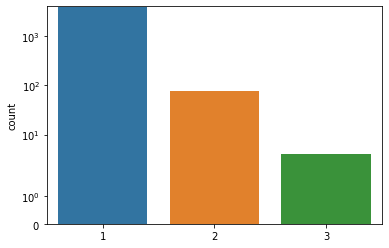

In [19]:
sns.countplot(x=counts)
plt.yscale('symlog')

In [20]:
## creating an array which indicates if the corresponding gene in our dataset is duplicated or not.
multiple = np.zeros_like(names)
for gene in range(len(names)):
    if np.size(np.where(names==names[gene])[0])>1:
        multiple[gene] = 1

### Compiling the essentiality labels (after excluding the duplicated genes)

In [21]:
tradis_dict = {0: 'Essential', 1: 'Nonessential', 2: 'Unclear'}

In [22]:
genes_included = np.sort(list(set(genes_int)-set(np.where(multiple)[0])))

In [25]:
print('Fraction of genes retained after removing genes with potential duplicates\n',len(genes_included)/len(names))

Fraction of genes retained after removing genes with potential duplicates
 0.9581777445855115


Counting number of genes which are present in TraDIS/Keio datasets, or synonym of the gene is present in TraDIS/Keio datasets

In [68]:
count1=0
count2=0
count3=0
for gene in genes_included:
    if names[gene] in list(tradis['Gene']):
        count1+=1
    elif names[gene] in synonym_dict_tradis.keys():
        count2+=1
        print(names[gene])
    else:
        count3+=1
print('Gene names present in TraDIS data:', count1)
print('Synonym of gene names present in TraDIS data:', count2)
print('Not present in TraDIS data:', count3)

araA
lpdA
rpnC
thpR
mtnN
trmO
pdeL
yahH
iprA
dgcC
ppnP
decR
atl
pdeB
cnoX
selU
arcC
fimZ
hcxA
dpiB
dpiA
crcB
nagD
phrB
pxpB
pxpC
pxpA
ybgU
cpoB
cecR
hcxB
opgE
ybiS
dgcI
lysO
elyC
cmoM
ycbB
gloC
appC
appB
appX
dgcT
mdoC
mdoG
mdoH
trhO
mltG
comR
ycfS
pdeG
trpGD
ymiC
lapA
lapB
pdeR
dgcM
zntB
ydbK
mdoD
sutR
rlhA
ortT
digH
mgtS
fumD
ynhG
selO
hxpB
tcyP
cdgI
dgcJ
nimR
nimT
dgcP
pdeD
hprS
hprR
msrP
msrQ
erfK
galF
gmm
fcl
dgcE
pphC
trhP
btsR
btsS
pdeN
radD
hxpA
rpnB
yfcN
pdeA
perM
pdeF
yfiC
tapT
patZ
dgcN
glaH
lhgD
glaR
kbp
gutM
gutQ
surE
ppnN
ghxQ
ygfX
ygfA
fumE
yqgD
sprT
hemW
trmB
yqiD
ubiK
uppP
dlsT
ubiT
ubiU
ubiV
rapZ
ptsO
zapE
envR
pckA
rpnA
yrhD
panZ
pdeH
pdeK
lyx
gpmI
yibD
rfaF
rfaC
rfaL
rfaJ
rfaY
rfaI
rfaP
rfaG
rfaQ
coaBC
adeQ
adeP
gppA
bioP
xynR
engB
bipA
rhaA
rhaB
ptsA
htrC
ghxP
rpiR
ghoS
ghoT
gdx
yjiE
ytiA
btsT
farR
lgoT
lgoD
mdoB
ettA
gpmB
lasT
Gene names present in TraDIS data: 3459
Synonym of gene names present in TraDIS data: 173
Not present in TraDIS data: 217


In [65]:
count1=0
count2=0
count3=0
for gene in genes_included:
    if names[gene] in list(keio_all['gene']):
        count1+=1
    elif names[gene] in synonym_dict_keio.keys():
        count2+=1
    else:
        count3+=1
print('Gene names present in Keio data:', count1)
print('Synonym of gene names present in Keio data:', count2)
print('Not present in Keio data:', count3)

Gene names present in Keio data: 3103
Synonym of gene names present in Keio data: 526
Not present in Keio data: 220


Overall, we end up with ~3600 genes which are shared (with high confidence) between the TraDIS/Keio collection datasets, and our TnSeq data.

In [257]:
labels_tradis = []
indices_tradis = []

for gene in genes_included:
    label_dict = {}
    ### step 1: essentiality as predicted in the TraDIS dataset
    if names[gene] in list(tradis['Gene']):
        indices_tradis.append(gene)
        #identifying the row in the tradis data corresponding to this gene, extracting only the last three columns
        #which contain information about gene essentiality
        key = np.where(list(tradis.iloc[np.where(tradis['Gene']==names[gene])[0][0], -3:]))[0][0]
        #the idea behind np.where is that one of the columns is necessarily true, and the above line will return 
        #which of the columns is true. This is then mapped to essentiality status
        label_dict['TraDIS'] = tradis_dict[key]
        labels.append(label_dict)
    
    elif names[gene] in synonym_dict_tradis.keys():
        

cra True
yadI True
flhA True
motB True
rob True
betT True
yahF True
yahG True
codB True
mhpD True
rhsD True
quuD True
essD True
rhsA True
hokE True
glpG True
nagA True
ybiI True
ompX True
ybiI True
dam True
ogrK True
ybjS True
kdsB False
rutF True
rutB True
acpP False
ldrB True
ldrB True
ldrB True
puuC True
ugpC True
rrrQ True
ydfK True
gapA False
rhsD True
fdnG True
fdnG True
fimD True
fimD True
ydfK True
ompX True
rrrQ True
essD True
gadW True
blc True
quuD True
ynfM True
ydhB True
ydiF True
gapA False
fadD True
flhA True
motB True
arnB True
wzxC True
wzxC True
ogrK True
sgcC True
yehI True
yehI True
mdtP True
rhmA True
rhmT True
arnB True
arnC True
hyfD True
hyfD True
ynfM True
hokE True
cra True
rbsB True
rbsC True
rbsA True
kduD True
yqeA True
kdsD True
kdsB False
malK True
gspK True
gspG True
gspF True
gspE True
gspD True
fadD True
ybjS True
acpP False
kbl True
lptG False
ytfJ True
ysgA True
exuT True
agaC True
agaD True
yadI True
nagA True
agaC True
agaD True
kdsD True
gspD True

SOmething weird is happening. There are ~80 genes names which show up more 

In [17]:
tradis

,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,thrL,0.393939,31.431059,False,True,False
1,thrA,0.219245,17.200782,False,True,False
2,thrB,0.265809,21.234549,False,True,False
3,thrC,0.205905,15.994924,False,True,False
4,yaaX,0.225589,17.765507,False,True,False
...,...,...,...,...,...,...
4308,creC,0.220351,17.299624,False,True,False
4309,creD,0.221729,17.422589,False,True,False
4310,arcA,0.097629,4.641238,False,True,False
4311,yjjY,0.219858,17.255613,False,True,False


In [31]:
np.size(np.where(names=='exuT')[0])

3

In [104]:
tradis

,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,thrL,0.393939,31.431059,False,True,False
1,thrA,0.219245,17.200782,False,True,False
2,thrB,0.265809,21.234549,False,True,False
3,thrC,0.205905,15.994924,False,True,False
4,yaaX,0.225589,17.765507,False,True,False
...,...,...,...,...,...,...
4308,creC,0.220351,17.299624,False,True,False
4309,creD,0.221729,17.422589,False,True,False
4310,arcA,0.097629,4.641238,False,True,False
4311,yjjY,0.219858,17.255613,False,True,False


In [62]:
keio_all

,gene
0,thrL
1,thrA
2,thrB
3,thrC
4,yaaX
...,...
4373,creC
4374,creD
4375,arcA
4376,yjjY


In [67]:
np.where(names=='exuT')[0].shape[0]

3

In [69]:
synonym_dict_keio['uppP']

['bacA']

In [76]:
rbtn = pd.read_csv('/Users/anuraglimdi/Downloads/fit_genes.tab',sep='\t')

In [108]:
a = set(rbtn['name'])-set(tradis['Gene'])

In [109]:
len(a)

874

In [110]:
b = set(tradis['Gene'])&set(rbtn['name'])

In [111]:
len(b)

3614

In [112]:
len(rbtn['name'])

4610

In [113]:
874+3614

4488